# Spherical coordinates in shenfun

The Helmholtz equation is given as

$$
-\nabla^2 u + \alpha u = f.
$$

In this notebook we will solve this equation on a unitsphere, using spherical coordinates. To verify the implementation we use a spherical harmonics function as manufactured solution. 

We start the implementation by importing necessary functionality from shenfun and sympy:

In [1]:
from shenfun import *
from shenfun.la import SolverGeneric1ND
import sympy as sp

Define spherical coordinates $(r, \theta, \phi)$

$$
\begin{align}
x &= r \sin \theta \cos \phi \\
y &= r \sin \theta \sin \phi \\
z &= r \cos \theta
\end{align}
$$

using sympy. The radius `r` will be constant `r=1`. We create the three-dimensional position vector `rv` as a function of the two new coordinates $(\theta, \phi)$.

In [2]:
r = 1
theta, phi = psi = sp.symbols('x,y', real=True, positive=True)
rv = (r*sp.sin(theta)*sp.cos(phi), r*sp.sin(theta)*sp.sin(phi), r*sp.cos(theta))

We define bases with the domains $\theta \in [0, \pi]$ and $\phi \in [0, 2\pi]$. Also define a tensorproductspace, test- and trialfunction. Note that the new coordinates and the position vector are fed to the `TensorProductSpace` and not the individual spaces:  

In [3]:
N, M = 256, 256
L0 = FunctionSpace(N, 'L', domain=(0, np.pi))
F1 = FunctionSpace(M, 'F', dtype='D')
T = TensorProductSpace(comm, (L0, F1), coordinates=(psi, rv, sp.Q.positive(sp.sin(theta))))
v = TestFunction(T)
u = TrialFunction(T)

Use one spherical harmonic function as a manufactured solution

In [4]:
#sph = sp.functions.special.spherical_harmonics.Ynm
#ue = sph(6, 3, theta, phi)
ue = sp.cos(8*(sp.sin(theta)*sp.cos(phi) + sp.sin(theta)*sp.sin(phi) + sp.cos(theta)))

Compute the right hand side on the quadrature mesh and take the scalar product

In [5]:
alpha = 1000
g = (-div(grad(u))+alpha*u).tosympy(basis=ue, psi=psi)
gj = Array(T, buffer=g*T.coors.sg)
g_hat = Function(T)
g_hat = inner(v, gj, output_array=g_hat)

Note that we can use the `shenfun` operators `div` and `grad` on a trialfunction `u`, and then switch the trialfunction for a sympy function `ue`. The operators will then make use of sympy's [derivative method](https://docs.sympy.org/latest/tutorial/calculus.html#derivatives) on the function `ue`. Here `(-div(grad(u))+alpha*u)` corresponds to the equation we are trying to solve:

In [6]:
from IPython.display import Math
#Math((-div(grad(u))+alpha*u).tolatex(funcname='u', symbol_names={theta: '\\theta', phi: '\\phi'}))
Math((grad(u)).tolatex(funcname='u', symbol_names={theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>

Evaluated with `u=ue` and you get the exact right hand side `f`.

Tensor product matrices that make up the Helmholtz equation are then assembled as 

In [7]:
mats = inner(v, (-div(grad(u))+alpha*u)*T.coors.sg)

And the linear system of equations can be solved using the generic `SolverGeneric1ND`, that can be used for any problem that only has non-periodic boundary conditions in one dimension.

In [8]:
u_hat = Function(T)
Sol1 = SolverGeneric1ND(mats)
u_hat = Sol1(g_hat, u_hat)

Transform back to real space and compute the error.

In [9]:
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.sqrt(inner(1, (uj-uq)**2)), np.linalg.norm(uj-uq))

Error = (1.577897930352934e-11-1.1373644411543732e-16j) 4.486787304722357e-08


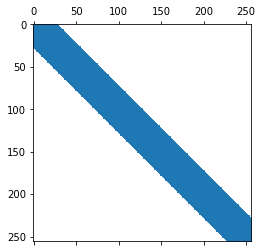

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.spy(Sol1.MM[1].diags())

## Postprocessing
Since we used quite few quadrature points in solving this problem, we refine the solution for a nicer plot. Note that `refine` simply pads Functions with zeros, which gives exactly the same accuracy, but more quadrature points in real space. `u_hat` has `NxM` quadrature points, here we refine using 3 times as many points along both dimensions

In [11]:
u_hat2 = u_hat.refine([N*3, M*3])
ur = u_hat2.backward(kind='uniform')

The periodic solution does not contain the periodic points twice, i.e., the computational mesh contains $0$, but not $2\pi$. It looks better if we wrap the periodic dimension all around to $2\pi$, and this is achieved with 

In [12]:
xx, yy, zz = u_hat2.function_space().local_cartesian_mesh(uniform=True)
xx = np.hstack([xx, xx[:, 0][:, None]])
yy = np.hstack([yy, yy[:, 0][:, None]])
zz = np.hstack([zz, zz[:, 0][:, None]])
ur = np.hstack([ur, ur[:, 0][:, None]])

In the end the solution is plotted using mayavi

In [13]:
from mayavi import mlab
#mlab.init_notebook()
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 400))
mlab.mesh(xx, yy, zz, scalars=ur.real, colormap='jet')
mlab.show()

# Biharmonic equation

A biharmonic equation is given as

$$
\nabla^4 u + \alpha u = f.
$$

This equation is extremely messy in spherical coordinates. I cannot even find it posted anywhere. Nevertheless, we can solve it trivially with shenfun, and we can also see what it looks like

In [14]:
Math((div(grad(div(grad(u))))+alpha*u).tolatex(funcname='u', symbol_names={theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>

Remember that this equation uses constant radius `r=1`. We now solve the equation using the same manufactured solution as for the Helmholtz equation.

In [15]:
g = (div(grad(div(grad(u))))+alpha*u).tosympy(basis=ue, psi=psi)
gj = Array(T, buffer=g)

# Take scalar product
g_hat = Function(T)
g_hat = inner(v, gj, output_array=g_hat)

mats = inner(v, div(grad(div(grad(u)))) + alpha*u)

# Solve
u_hat = Function(T)
Sol1 = SolverGeneric1ND(mats)
u_hat = Sol1(g_hat, u_hat)

# Transform back to real space.
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.sqrt(dx((uj-uq)**2)))


Error = (0.6846123925197591-6.1846242529207164e-15j)


Want to see what the regular 3-dimensional biharmonic equation looks like in spherical coordinates? This is extremely tedious to derive by hand, but in shenfun you can get there with the following few lines of code

In [16]:
r, theta, phi = psi = sp.symbols('x,y,z', real=True, positive=True)
rv = (r*sp.sin(theta)*sp.cos(phi), r*sp.sin(theta)*sp.sin(phi), r*sp.cos(theta))
L0 = FunctionSpace(20, 'L', domain=(0, 1))
F1 = FunctionSpace(20, 'L', domain=(0, np.pi))
F2 = FunctionSpace(20, 'F', dtype='D')
T = TensorProductSpace(comm, (L0, F1, F2), coordinates=(psi, rv, sp.Q.positive(sp.sin(theta))))
u = TrialFunction(T)
Math((div(grad(div(grad(u))))).tolatex(funcname='u', symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>

In [17]:
v = TestFunction(T)
A = inner(div(grad(v)), div(grad(u)), level=2)

I don't know if this is actually correct, because I haven't derived it by hand and I haven't seen it printed anywhere, but at least I know the Cartesian equation is correct:

In [18]:
L0 = FunctionSpace(8, 'C', domain=(0, np.pi))
F1 = FunctionSpace(8, 'F', dtype='D')
F2 = FunctionSpace(8, 'F', dtype='D')
T = TensorProductSpace(comm, (L0, F1, F2))
u = TrialFunction(T)
Math((div(grad(div(grad(u))))).tolatex(funcname='u'))

<IPython.core.display.Math object>